## IMPORTING LIBRARIES

In [ ]:
import os
import random
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

## IMPORTING DATASET FROM KAGGLE

In [ ]:
#loading kaggle api
! pip install -q kaggle
#uploading kaggle json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekkrsingh369","key":"9524a975c09251aa40b906d196892a23"}'}

In [ ]:
#creating directory for storage
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
#giving read/write permission
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#importing dataset using kaggle api
!kaggle competitions download -c digit-recognizer

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 189MB/s]


In [ ]:
! ls

digit-recognizer.zip  kaggle.json  sample_data


## UNZIPPING DATASET


In [ ]:
import zipfile

In [ ]:
zip_ref = zipfile.ZipFile("/content/digit-recognizer.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Removing sample_submission.csv
! rm sample_submission.csv

## TURNING DATASET INTO COMMON CATAGORICAL FOLDER FORMAT

In [ ]:
# Creating Numpy array from .csv file
testcsv = pd.read_csv('/content/test.csv')
traincsv =pd.read_csv("/content/train.csv")

In [ ]:
traincsv.shape,testcsv.shape

((42000, 785), (28000, 784))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
traincsv,validationcsv = train_test_split(traincsv,test_size=0.1)
traincsv.shape,validationcsv.shape

((37800, 785), (4200, 785))

In [ ]:
# Creating Respective folders
! mkdir train
! mkdir test
! mkdir validation

In [ ]:
#function to reshape and store each vector of pixel as a image
def reshape_and_store(pixel_vector,class_label,parent_directory,shape=(28,28),img_num=0,store=False):
    pixel_tensor=tf.reshape(pixel_vector, shape)
    store_dir=""
    if(class_label !=-1):
      class_label=str(class_label)
      store_dir=str(parent_directory+'/'+class_label)
    else:
      store_dir=str(parent_directory)
    img_num=str(img_num)
    img_num= '0'*(5-len(img_num))+img_num
    try:
      os.mkdir(store_dir)
      store_dir=store_dir+'/'+img_num+'.jpg'
    except:
      store_dir=store_dir+'/'+img_num+'.jpg'
    if store:
      cv2.imwrite(store_dir,np.array(pixel_tensor))
    #plt.figure()
    #plt.imshow(pixel_tensor,'gray')


In [ ]:
#train data conversion
for i in range(0,traincsv.axes[0].size):
  reshape_and_store(traincsv.iloc[i,1:],traincsv.iloc[i,0],'/content/train',(28,28),i,True)

In [ ]:
#creating validation data
for i in range(0,validationcsv.axes[0].size):
  reshape_and_store(validationcsv.iloc[i,1:],validationcsv.iloc[i,0],'/content/validation',(28,28),i,True)

In [ ]:
#test data conversion
for i in range(0,testcsv.axes[0].size):
  reshape_and_store(testcsv.iloc[i,:],-1,'/content/test',(28,28),i,True)

In [ ]:
# Function for viewing random images
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (28, 28)


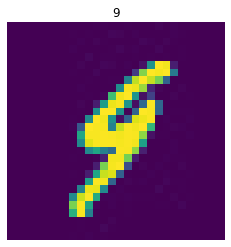

In [ ]:
img=view_random_image(target_dir="validation/",
                        target_class="9")

### TURNING DATA INTO IMAGE DATASET

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
tf.random.set_seed(42)
IMG_SIZE=(28,28)
train_data=image_dataset_from_directory('/content/train',color_mode='grayscale',label_mode='categorical',shuffle=True,image_size=IMG_SIZE)
validation_data=image_dataset_from_directory('/content/validation',color_mode='grayscale',label_mode='categorical',shuffle=True,image_size=IMG_SIZE)
#

Found 37800 files belonging to 10 classes.
Found 4200 files belonging to 10 classes.


In [ ]:
train_data,validation_data

(<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>)

## Creating a CNN model using Transfer learning and feature extraction

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import smart_resize
import tensorflow_hub as hub

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# Creating model using functional api
inputs = layers.Input((28,28,1),name='Input layer')
x = smart_resize(inputs,(224,224))
x = Dense(3)(x)
x = base_model(x)
x = GlobalAvgPool2D()(x)
outputs = layers.Dense(10,activation='softmax',name='output_layer')(x)


In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=["accuracy"])

In [ ]:
val_data=validation_data

In [ ]:
model.fit(train_data,epochs=5,steps_per_epoch=len(train_data),validation_data=val_data,validation_steps=(0.20*len(val_data)),verbose=1)

Epoch 1/5
1182/1182 [==============================] - 280s 221ms/step - loss: 0.5446 - accuracy: 0.8535 - val_loss: 0.2071 - val_accuracy: 0.9387
Epoch 2/5
1182/1182 [==============================] - 261s 221ms/step - loss: 0.2063 - accuracy: 0.9422 - val_loss: 0.1568 - val_accuracy: 0.9537
Epoch 3/5
1182/1182 [==============================] - 263s 222ms/step - loss: 0.1570 - accuracy: 0.9539 - val_loss: 0.1069 - val_accuracy: 0.9757
Epoch 4/5
1182/1182 [==============================] - 261s 221ms/step - loss: 0.1348 - accuracy: 0.9597 - val_loss: 0.0987 - val_accuracy: 0.9722
Epoch 5/5
1182/1182 [==============================] - 263s 222ms/step - loss: 0.1167 - accuracy: 0.9650 - val_loss: 0.0948 - val_accuracy: 0.9699


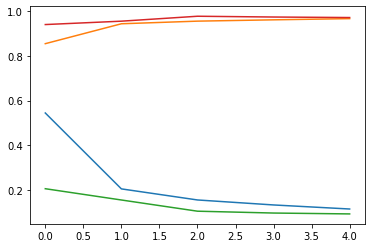

In [ ]:
plt.plot(pd.DataFrame(model.history.history))

In [ ]:
model.evaluate(val_data)

132/132 [==============================] - 9s 67ms/step - loss: 0.1041 - accuracy: 0.9683


[0.10412155836820602, 0.9683333039283752]

## CREATING SUBMISSION.CSV FOR KAGGLE SUBMISSION

In [ ]:
class_names = train_data.class_names

In [ ]:
test_data=image_dataset_from_directory('/content/test/',color_mode='grayscale',shuffle=False,image_size=IMG_SIZE,label_mode=None)


Found 28000 files belonging to 1 classes.


In [ ]:
pred=model.predict(test_data)

In [ ]:
classpred=[[j+1,int(class_names[tf.argmax(pred[j])])] for j in range(0,len(pred)) ]

In [ ]:
newdf = pd.DataFrame(np.array(classpred) , columns=['ImageId','Label'])

In [ ]:
newdf.to_csv('submission.csv',index=False)